In [1]:
import jwst
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import match_coordinates_sky,SkyCoord, Angle
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

band = "clear-f444w"
# path = "../../JWST/MAST_M16_Nov142022/JWST/jw02739-o001_t001_nircam_" # M16 - Pillars of Creation
path = "../../ngc3324/NIRCAM_ALL/JWST/jw02731-o001_t017_nircam_" # NGC 3324 - Cosmic Cliffs

In [2]:
# band = 'f770w'
# t = Table.read(path+band+"/jw02739-o001_t001_nircam_"+band+"_cat.ecsv") # M16 - Pillars of Creation
t = Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv") # NGC 3324 - Cosmic Cliffs

t.info()

<Table length=19438>
         name           dtype    unit  format                                                                  description                                                                    class   n_bad
---------------------- ------- ------- ------ ---------------------------------------------------------------------------------------------------------------------------------------------- -------- -----
                 label   int64                                                                                                                     Unique source identification label number   Column     0
             xcentroid float64            .4f                                                                                                           X pixel value of the source centroid   Column     0
             ycentroid float64            .4f                                                                                                           Y pixel val

In [3]:
t[0]

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,SkyCoord,SkyCoord,SkyCoord,SkyCoord
1,1402.4651,5.2563,"159.128782264561,-58.64827782656696",2.367515e-08,2.379369e-09,2.881952e-06,2.579770e-01,5.330840e-06,3.593793e-01,9.364939e-06,nan,1.380298e-05,nan,22.750783,12.379748,22.083011,12.071910,21.471238,nan,21.050068,nan,19.508973,12.379748,18.841201,12.071910,18.229428,nan,17.808258,nan,1.8497,1.7567,3.2495,False,0.492454,-0.182825,19,10.373418,1.092490e-05,6.286873e-01,21.303956,11.900062,18.062146,11.900062,41.0,1.665399,1.136459,0.317606,-0.669063,192.218911,"159.12868738034283,-58.64835549821717","159.12888376911735,-58.648379012613205","159.1287627050977,-58.64818520006982","159.12895909296532,-58.64820871435099"


To brute force make a catalogue:

1) Start with the filter that has the most sources
2) Take the brightest source, grab it's RA/DEC, relate the size of it's 1-sigma psf size to deg and use this as tolerance.
3) Find all other objects in all other filters that are located within this tolerance
4) Take those filter mags/fluxes and plop into new dataframe
5) If one source has multiple objects associated with it in other filters, add them all into the rows and add a flag

In [4]:

path_m = "../../ngc3324/MIRI_ALL/JWST/jw02731-o002_t017_miri_"
t = []

for i, band in enumerate(['clear-f090w', 'clear-f187n', 'clear-f200w', 'clear-f335m', 'clear-f444w', 'f444w-f470n']):
    # Get the tables
    # t.append(Table.read(path+band+"/jw02739-o001_t001_nircam_"+band+"_cat.ecsv")) # M16 - Pillars of Creation
    t.append(Table.read(path+band+"/jw02731-o001_t017_nircam_"+band+"_cat.ecsv")) # NGC 3324 - Cosmic Cliffs
    print(len(t[i]))


for i, band in enumerate(['f770w', 'f1130w', 'f1280w', 'f1800w']):
    # Get the tables
    t.append(Table.read(path_m+band+"/jw02731-o002_t017_miri_"+band+"_cat.ecsv"))
    print(len(t[i+6]))



20401
32372
44867
16663
19438
18984
592
412
410
310


In [5]:
meas_type = 'vegamag'
meas_type2 = 'flux'
ap_type = 'isophotal'
ap_type2 = 'aper30'
ap_type3 = 'aper50'
ap_type4 = 'aper70'
ap_type5 = 'aper_total'

for i, f in enumerate(['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']):
    print(f)
    if i < 3:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.031/3600 # Convert pixels to arcseconds, arcseconds to degrees (F090,187,200)
    elif i<6:
        print(f)
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.063/3600 # Convert pixels to arcseconds, arcseconds to degrees (F335,444,470) 
    else:
        t[i]['size'] = np.sqrt((t[i]['semimajor_sigma']**2)+t[i]['semiminor_sigma']**2)*0.11/3600 # Convert pixels to arcseconds, arcseconds to degrees (MIRI)
    
    t[i] = t[i].to_pandas()[['sky_centroid.ra', 'sky_centroid.dec','size', ap_type+'_'+meas_type, ap_type+'_'+meas_type+'_err', \
        ap_type2+'_'+meas_type, ap_type2+'_'+meas_type+'_err', ap_type3+'_'+meas_type, ap_type3+'_'+meas_type+'_err',\
            ap_type4+'_'+meas_type, ap_type4+'_'+meas_type+'_err',ap_type5+'_'+meas_type, ap_type5+'_'+meas_type+'_err',\
                ap_type+'_'+meas_type2, ap_type+'_'+meas_type2+'_err', \
        ap_type2+'_'+meas_type2, ap_type2+'_'+meas_type2+'_err', ap_type3+'_'+meas_type2, ap_type3+'_'+meas_type2+'_err',\
            ap_type4+'_'+meas_type2, ap_type4+'_'+meas_type2+'_err',ap_type5+'_'+meas_type2, ap_type5+'_'+meas_type2+'_err']]
    t[i].rename(columns={'sky_centroid.ra': 'RA', 'sky_centroid.dec': 'DEC',ap_type+'_'+meas_type:ap_type+'_'+meas_type+'_'+f, ap_type+'_'+meas_type+'_err': ap_type+'_'+meas_type+'_err_'+f,\
        ap_type2+'_'+meas_type:ap_type2+'_'+meas_type+'_'+f, ap_type2+'_'+meas_type+'_err': ap_type2+'_'+meas_type+'_err_'+f,ap_type3+'_'+meas_type:ap_type3+'_'+meas_type+'_'+f, ap_type3+'_'+meas_type+'_err': ap_type3+'_'+meas_type+'_err_'+f,\
            ap_type4+'_'+meas_type:ap_type4+'_'+meas_type+'_'+f, ap_type4+'_'+meas_type+'_err': ap_type4+'_'+meas_type+'_err_'+f,ap_type5+'_'+meas_type:ap_type5+'_'+meas_type+'_'+f, ap_type5+'_'+meas_type+'_err': ap_type5+'_'+meas_type+'_err_'+f,\
                ap_type+'_'+meas_type2:ap_type+'_'+meas_type2+'_'+f, ap_type+'_'+meas_type2+'_err': ap_type+'_'+meas_type2+'_err_'+f,\
        ap_type2+'_'+meas_type2:ap_type2+'_'+meas_type2+'_'+f, ap_type2+'_'+meas_type2+'_err': ap_type2+'_'+meas_type2+'_err_'+f,ap_type3+'_'+meas_type2:ap_type3+'_'+meas_type2+'_'+f, ap_type3+'_'+meas_type2+'_err': ap_type3+'_'+meas_type2+'_err_'+f,\
            ap_type4+'_'+meas_type2:ap_type4+'_'+meas_type2+'_'+f, ap_type4+'_'+meas_type2+'_err': ap_type4+'_'+meas_type2+'_err_'+f,ap_type5+'_'+meas_type2:ap_type5+'_'+meas_type2+'_'+f, ap_type5+'_'+meas_type2+'_err': ap_type5+'_'+meas_type2+'_err_'+f},inplace=True)

data_all_filters_NIRCam_MIRI = pd.concat([t[0],t[1],t[2],t[3],t[4],t[5],t[6],t[7],t[8],t[9]],ignore_index=True) # MIRI: ,t[6],t[7],t[8],t[9]
data_all_filters_NIRCam_MIRI.sort_values(ap_type+'_'+meas_type+'_f444w-f470n', ascending=True,inplace=True)
data_all_filters_NIRCam_MIRI.reset_index(drop=True,inplace=True)

f090w
f187n
f200w
f335m
f335m
f444w
f444w
f444w-f470n
f444w-f470n
f770w
f1130w
f1280w
f1800w


(array([8.1198e+04, 5.3647e+04, 1.0383e+04, 3.0830e+03, 1.4890e+03,
        9.6200e+02, 6.4600e+02, 4.4600e+02, 3.4100e+02, 2.7200e+02,
        2.3900e+02, 1.9100e+02, 1.6300e+02, 1.5700e+02, 1.3000e+02,
        1.0000e+02, 8.4000e+01, 6.6000e+01, 5.5000e+01, 3.7000e+01,
        5.5000e+01, 4.6000e+01, 4.2000e+01, 4.1000e+01, 4.0000e+01,
        2.0000e+01, 2.5000e+01, 1.5000e+01, 2.1000e+01, 2.1000e+01,
        1.5000e+01, 2.5000e+01, 1.3000e+01, 1.3000e+01, 1.3000e+01,
        1.2000e+01, 9.0000e+00, 1.2000e+01, 1.4000e+01, 1.4000e+01,
        1.0000e+01, 8.0000e+00, 9.0000e+00, 1.3000e+01, 1.2000e+01,
        4.0000e+00, 7.0000e+00, 7.0000e+00, 7.0000e+00, 6.0000e+00,
        8.0000e+00, 8.0000e+00, 7.0000e+00, 3.0000e+00, 4.0000e+00,
        1.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00, 7.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00,
        5.0000e+00, 5.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00,
        4.0000e+00, 1.0000e+01, 3.0000e+00, 5.00

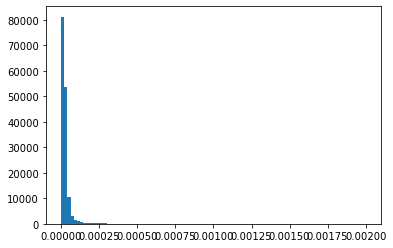

In [6]:
plt.hist(data_all_filters_NIRCam_MIRI['size'],bins=np.linspace(0,0.002,100))

In [13]:
def strip_cand(df, sortby, tol=1/3600):
    """
    Originally written by S. Smith, UVic 2022, edited by B. Crompvoets UVic 2022

    For a pandas dataframe filled with unsorted candidates, 
    select the first row, select all neighbours within the df, 
    and keep only the most significant. Strip all neighbours and 
    reference source from the original df. Return the striped df, 
    along with the row values of the most significant member.
    
    Parameters:
    -----------
    
    df  : Pandas DataFrame object, candidates
    tol : Neighbour tollerance, in degrees (recommended, tol = 0.5)
    
    Returns:
    -----------
    
    rest  : Pandas Dataframe object, striped of one candidate member group
    row : Numpy Array object, highest significance candidate from group
    """

    i, j = df.iloc[0]['RA'], df.iloc[0]['DEC'] #Select RA/Dec of first item in the df
    prox = np.sqrt((df['RA']-i)**2 + (df['DEC']-j)**2) < df.iloc[0]['size'] #Find boolean locations of all neighbours within tol (in degrees)
    invest = df[prox].sort_values(sortby, ascending=True).reset_index(drop=True) #Define new df 'investigate' made up of all group members
    #row = np.array(invest.iloc[0]) #Take highest sig group member and put in np.array object
    rest = df[~prox].reset_index(drop=True) #Define new df 'the rest' made up of all the other rows
    
    return rest, invest

In [14]:
rest, row = strip_cand(data_all_filters_NIRCam_MIRI,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=data_all_filters_NIRCam_MIRI['size'])

for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
    ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
    row.loc[0,'RA'] = np.mean(row[['RA']].values)
    row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
    for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
        row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

catalog = row.head(1)
catalog

,RA,DEC,size,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err_f090w,aper70_vegamag_f090w,...,isophotal_flux_f1800w,isophotal_flux_err_f1800w,aper30_flux_f1800w,aper30_flux_err_f1800w,aper50_flux_f1800w,aper50_flux_err_f1800w,aper70_flux_f1800w,aper70_flux_err_f1800w,aper_total_flux_f1800w,aper_total_flux_err_f1800w
0,159.224543,-58.608022,0.001592,20.270936,12.898281,NaN,NaN,NaN,NaN,NaN,...,0.594056,2436.375,0.000463,1.492086,0.001855,2.782641,0.015399,10.509079,0.022809,15.566172


In [15]:
# Run through once to get closest objects
length = True
i = 0


while length:
    rest, row = strip_cand(rest,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=rest['size'])
    
    for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
        ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
        row.loc[0,'RA'] = np.mean(row[['RA']].values)
        row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
        for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
            row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

    row = row.head(1)

    catalog = pd.concat([catalog, row])

    length = len(rest) > 0
    if i % 10000 == 0:
        print(len(rest))
    i = i+1
    
catalog.reset_index(inplace=True,drop=True)
print(len(catalog))

154395
115171
93634
74797
63633
52508
41817
31138
18990
7947
97130


In [17]:
# Run through a second time to catch objects which have been half located at one location and half at another
length = True
i = 0

rest, row = strip_cand(catalog,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=catalog['size'])

for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
    ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
    row.loc[0,'RA'] = np.mean(row[['RA']].values)
    row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
    for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
        row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
        row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

catalog = row.head(1)



while length:
    rest, row = strip_cand(rest,sortby=ap_type+'_'+meas_type+'_f444w-f470n',tol=rest['size'])

    for f in ['f090w', 'f187n', 'f200w', 'f335m', 'f444w', 'f444w-f470n','f770w', 'f1130w', 'f1280w', 'f1800w']:
        ind = np.c_[0,np.where(row[ap_type+'_'+meas_type+'_'+f].where(row[ap_type+'_'+meas_type+'_'+f]==np.amin(row[ap_type+'_'+meas_type+'_'+f]),False))]
        row.loc[0,'RA'] = np.mean(row[['RA']].values)
        row.loc[0,'DEC'] = np.mean(row[['DEC']].values)
        for ap in [ap_type, ap_type2, ap_type3, ap_type4, ap_type5]:
            row.loc[0,ap+'_'+meas_type+'_'+f] = row[[ap+'_'+meas_type+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type+'_err_'+f] = row[[ap+'_'+meas_type+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type2+'_'+f] = row[[ap+'_'+meas_type2+'_'+f]].iloc[ind[0][-1]].to_numpy()[0]
            row.loc[0,ap+'_'+meas_type2+'_err_'+f] = row[[ap+'_'+meas_type2+'_err_'+f]].iloc[ind[0][-1]].to_numpy()[0]

    row = row.head(1)

    catalog = pd.concat([catalog, row])

    length = len(rest) > 0
    if i % 10000 == 0:
        print(len(rest))
    i = i+1
    
catalog.reset_index(inplace=True,drop=True)
print(len(catalog))

97124


In [ ]:
# catalog_tab = Table.from_pandas(catalog[['RA','DEC','size',ap_type+'_'+meas_type+'_f090w', ap_type+'_'+meas_type+'_err_f090w', ap_type+'_'+meas_type+'_f187n', ap_type+'_'+meas_type+'_err_f187n',\
#     ap_type+'_'+meas_type+'_f200w', ap_type+'_'+meas_type+'_err_f200w',ap_type+'_'+meas_type+'_f335m', ap_type+'_'+meas_type+'_err_f335m',ap_type+'_'+meas_type+'_f444w', ap_type+'_'+meas_type+'_err_f444w',\
#         ap_type+'_'+meas_type+'_f444w-f470n', ap_type+'_'+meas_type+'_err_f444w-f470n']],units={'RA':'deg','DEC':'deg',ap_type+'_'+meas_type+'_f090w':'mag',ap_type+'_'+meas_type+'_err_f090w':'mag','size':'deg',\
#             ap_type+'_'+meas_type+'_f187n':'mag',ap_type+'_'+meas_type+'_err_f187n':'mag',ap_type+'_'+meas_type+'_f200w':'mag',ap_type+'_'+meas_type+'_err_f200w':'mag',\
#                 ap_type+'_'+meas_type+'_f335m':'mag',ap_type+'_'+meas_type+'_err_f335m':'mag',ap_type+'_'+meas_type+'_f444w':'mag',ap_type+'_'+meas_type+'_err_f444w':'mag',\
#                     ap_type+'_'+meas_type+'_f444w-f470n':'mag',ap_type+'_'+meas_type+'_err_f444w-f470n':'mag'})


# catalog_tab

In [ ]:
bands = [idx for idx in catalog.columns if (idx[:3] == 'iso' and idx[10]=='v')] 
webb_inp_dropped = catalog.dropna(thresh=2,subset=[idx for idx in bands if idx[-8]!='r' and idx[-13]!='r' and idx[10]=='v'])
print(len(webb_inp_dropped))
# webb_inp_dropped
webb_inp_dropped.to_csv('CC_JWST_NIRCAM_MIRI_Full_Dec142022_2pt_'+meas_type+'_'+meas_type2+'.csv')


23287


In [ ]:
# print("minumum RA: ",min(catalog.RA),"; maximum RA: ",max(catalog.RA))
# print("minumum DEC: ",min(catalog.DEC),"; maximum DEC: ",max(catalog.DEC))

spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
# print("Spitzer minumum RA: ",min(spit2m_cat.RAJ2000),"; maximum RA: ",max(spit2m_cat.RAJ2000))
# print("minumum DEC: ",min(spit2m_cat.DEJ2000),"; maximum DEC: ",max(spit2m_cat.DEJ2000))

d1 = np.where(np.array(spit2m_cat.DEJ2000)>min(catalog.DEC))
d2 = np.where(np.array(spit2m_cat.DEJ2000)<max(catalog.DEC))
D = d1[0][np.isin(d1[0],d2[0])]

r1 = np.where(np.array(spit2m_cat.RAJ2000)>min(catalog.RA))
r2 = np.where(np.array(spit2m_cat.RAJ2000)<max(catalog.RA))
R = r1[0][np.isin(r1[0],r2[0])]

A = D[np.isin(D,R)]

print('There are approximately',len(A),'Spitzer identified objects within the Webb field.')

There are approximately 554 Spitzer identified objects within the Webb field.


In [ ]:

meas_type = 'vegamag'
meas_type2 = 'flux'
ap_type = 'isophotal'
ap_type2 = 'aper30'
ap_type3 = 'aper50'
ap_type4 = 'aper70'
ap_type5 = 'aper_total'
# catalog_tab.write('CC_JWST_Full_Nov042022_'+meas_type+'.ecsv', format='ascii.ecsv',overwrite=True)
# catalog.to_csv('M16_JWST_Full_Nov162022_'+meas_type+'.csv')
# catalog.to_csv(cat_file)

In [ ]:
jwst_cat = pd.read_csv('CC_JWST_NIRCAM_MIRI_Full_Dec142022_2pt_'+meas_type+'_'+meas_type2+'.csv')

# Now that we have a catalogue of all JWST data, link Spitzer/2MASS

In [ ]:
# jwst_cat = pd.read_csv('CC_JWST_NIRCAM_MIRI_Full_Dec52022_2pt_'+meas_type+'_'+meas_type2+'.csv')
# jwst_cat = catalog
spit2m_cat = pd.read_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/NGC_3324_w_Preds.csv')
spicy_cat = pd.read_csv('/Users/breannacrompvoets/Documents/Star_Formation/YSO+Classification/Archive/SPICY_YSO_SubClasses.csv',comment='#')

j_sky = SkyCoord(jwst_cat.RA*u.deg, jwst_cat.DEC*u.deg)
# jwst_cat.drop(['RA','DEC'], axis=1, inplace=True)
s2_sky = SkyCoord(spit2m_cat.RAJ2000*u.deg, spit2m_cat.DEJ2000*u.deg)
sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)
# spit2m_cat.drop(['RAJ2000','DEJ2000'], axis=1, inplace=True)

print(ap_type)
# print(jwst_cat.shape)
# print(spit2m_cat.shape)


idx, sep2d, x = match_coordinates_sky(j_sky, s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < np.array(jwst_cat['size']*2)*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = jwst_cat[sep_constraint]
s2_matches = spit2m_cat.iloc[idx[sep_constraint]]

j_matches.reset_index(drop=True,inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_cat = pd.concat([j_matches,s2_matches],axis=1)

isophotal
346


In [ ]:
jwst_spitz_cat

,Unnamed: 0,RA,DEC,size,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err_f090w,...,mag_IR1,e_mag_IR1,mag_IR2,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha,Preds
0,0,159.225740,-58.614791,0.001592,NaN,NaN,NaN,NaN,NaN,NaN,...,12.012,0.165,11.736,0.155,10.058,0.199000,18.350,0.119339,-13.66696,2.0
1,1,159.267083,-58.580510,0.000903,13.018948,9.499820,26.101178,16.808694,25.728937,17.127796,...,7.416,0.044,6.873,0.049,6.399,0.033000,5.622,0.024000,-0.76836,0.0
2,3,159.178134,-58.562264,0.001339,10.788224,8.623969,18.994490,13.663846,17.438456,12.872796,...,7.651,0.040,7.792,0.054,7.715,0.037000,7.602,0.030000,-2.50840,0.0
3,4,159.250975,-58.592640,0.000799,12.768613,8.807995,26.707967,16.277158,25.058784,15.366050,...,8.670,0.056,7.916,0.042,7.082,0.033000,5.858,0.025000,0.55512,0.0
4,5,159.225224,-58.626385,0.002905,NaN,NaN,NaN,NaN,NaN,NaN,...,12.172,0.057,12.170,0.107,11.619,0.182000,18.350,0.119339,-12.95520,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,45197,159.250262,-58.591194,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,...,12.021,0.064,11.591,0.075,11.087,0.080000,9.977,0.075000,-0.17304,0.0
342,50164,159.276678,-58.588333,0.000087,NaN,NaN,NaN,NaN,NaN,NaN,...,11.699,0.058,11.233,0.096,10.969,0.095000,10.266,0.056000,-1.23412,0.0
343,66059,159.194087,-58.634834,0.000113,NaN,NaN,NaN,NaN,NaN,NaN,...,14.619,0.204,13.236,0.150,18.524,0.144951,18.350,0.119339,-11.20696,2.0
344,85685,159.196622,-58.636152,0.000089,NaN,NaN,NaN,NaN,NaN,NaN,...,12.304,0.071,10.960,0.086,9.799,0.064000,8.857,0.066000,0.62892,0.0


In [ ]:
# ADD SPICY PREDS
j_sky = SkyCoord(jwst_spitz_cat.RA*u.deg, jwst_spitz_cat.DEC*u.deg)
sp_sky = SkyCoord(spicy_cat['     RAdeg      DEdeg'].to_numpy(),unit=u.deg)

idx, sep2d, _ = match_coordinates_sky(j_sky, sp_sky, nthneighbor=1, storekdtree='kdtree_sky')
sep_constraint = sep2d < np.array(jwst_spitz_cat['size']*2)*u.deg

print(np.count_nonzero(sep_constraint))

j_matches = jwst_spitz_cat[sep_constraint]
s2_matches = spicy_cat.iloc[idx[sep_constraint]]

j_matches.reset_index(inplace=True)
s2_matches.reset_index(drop=True,inplace=True)

jwst_spitz_spicy_cat = pd.concat([j_matches,s2_matches[[' SPICY','class    ']]],axis=1)

25


In [ ]:
spicy_df_to_add = pd.DataFrame(data={'SPICY':jwst_spitz_spicy_cat[' SPICY'].values,'SPICY_Class':jwst_spitz_spicy_cat['class    '].values},index=jwst_spitz_spicy_cat['index'])

jwst_spitz_spicy_cat = pd.concat([jwst_spitz_cat,spicy_df_to_add],axis=1)

jwst_spitz_spicy_cat.drop('Unnamed: 0',axis=1,inplace=True)


In [ ]:
jwst_spitz_spicy_cat['SPICY_Class_0/1'] = 0
spicy_ind = np.where(np.isnan(jwst_spitz_spicy_cat.SPICY))[0]
jwst_spitz_spicy_cat['SPICY_Class_0/1'].loc[spicy_ind] = 1

/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_27982/3591459898.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jwst_spitz_spicy_cat['SPICY_Class_0/1'].loc[spicy_ind] = 1


In [ ]:
def mag_to_Jy(m, F0):
    F = F0*(10**(-m/2.5))
    return F
def e_mag_to_Jy(e_m, m, F0):
    e_F = (F0*np.log(10)/(2.5))*10**(-m/2.5)*(e_m)
    return e_F
band_names = [idx for idx in jwst_spitz_cat.columns if (idx[:3] == 'mag' or idx[:5] == 'e_mag')]
spitz_fluxes = pd.DataFrame()
print(band_names)
for i, F_0 in enumerate([1594, 1594, 1024, 1024, 666.7,666.7,277.500, 277.500, 179.500, 179.500, 116.600, 116.600, 63.100, 63.100]):
    if i%2!=0:
        spitz_fluxes[band_names[i]] = e_mag_to_Jy(e_m=jwst_spitz_cat[band_names[i]].values,m=jwst_spitz_cat[band_names[i-1]].values,F0=F_0) # Convert errors in a column to flux
    else:
        spitz_fluxes[band_names[i]] = mag_to_Jy(m=jwst_spitz_cat[band_names[i]].values,F0=F_0) # Convert mags in a column to fluxes

spitz_fluxes.rename(columns={'mag_J':'f_J', 'e_mag_J':'e_f_J', 'mag_H':'f_H', 'e_mag_H':'e_f_H', 'mag_Ks':'f_Ks', 'e_mag_Ks':'e_f_Ks',\
    'mag_IR1':'f_IR1', 'e_mag_IR1':'e_f_IR1', 'mag_IR2':'f_IR2', 'e_mag_IR2':'e_f_IR2', 'mag_IR3':'f_IR3', 'e_mag_IR3':'e_f_IR3', 'mag_IR4':'f_IR4', 'e_mag_IR4':'e_f_IR4'},inplace=True)

spitz_fluxes    


['mag_J', 'e_mag_J', 'mag_H', 'e_mag_H', 'mag_Ks', 'e_mag_Ks', 'mag_IR1', 'e_mag_IR1', 'mag_IR2', 'e_mag_IR2', 'mag_IR3', 'e_mag_IR3', 'mag_IR4', 'e_mag_IR4']


,f_J,e_f_J,f_H,e_f_H,f_Ks,e_f_Ks,f_IR1,e_f_IR1,f_IR2,e_f_IR2,f_IR3,e_f_IR3,f_IR4,e_f_IR4
0,0.000002,9.949304e-08,0.000004,1.752866e-07,0.000003,1.773250e-07,0.004350,0.000661,0.003628,0.000518,0.011053,2.025943e-03,0.000003,3.170200e-07
1,0.078287,1.586305e-03,0.133506,2.828157e-03,0.223836,4.741699e-03,0.299822,0.012150,0.319790,0.014432,0.321439,9.769856e-03,0.355819,7.865318e-03
2,0.774976,1.784448e-02,0.771791,2.985554e-02,0.572704,1.160456e-02,0.241470,0.008896,0.137172,0.006822,0.095653,3.259687e-03,0.057442,1.587180e-03
3,0.033519,1.852317e-03,0.048161,2.439711e-03,0.075081,2.074567e-03,0.094463,0.004872,0.122367,0.004734,0.171356,5.208206e-03,0.286305,6.592423e-03
4,0.008833,7.484311e-04,0.009716,7.427689e-04,0.007797,3.590675e-04,0.003754,0.000197,0.002433,0.000240,0.002625,4.399928e-04,0.000003,3.170200e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.001572,1.795501e-04,0.002913,3.782638e-04,0.004265,1.689175e-04,0.004314,0.000254,0.004146,0.000286,0.004284,3.156925e-04,0.006445,4.452114e-04
342,0.002946,2.306656e-04,0.004308,3.729954e-04,0.004532,2.546455e-04,0.005803,0.000310,0.005766,0.000510,0.004776,4.179245e-04,0.004939,2.547376e-04
343,0.000002,9.949304e-08,0.000004,1.752866e-07,0.000003,1.773250e-07,0.000394,0.000074,0.000911,0.000126,0.000005,6.061700e-07,0.000003,3.170200e-07
344,0.000002,9.949304e-08,0.000004,1.752866e-07,0.000003,1.773250e-07,0.003324,0.000217,0.007414,0.000587,0.014031,8.270927e-04,0.018081,1.099130e-03


In [ ]:
jwst_spitz_cat[spitz_fluxes.columns] = spitz_fluxes

Text(0.5, 1.0, 'aper_total')

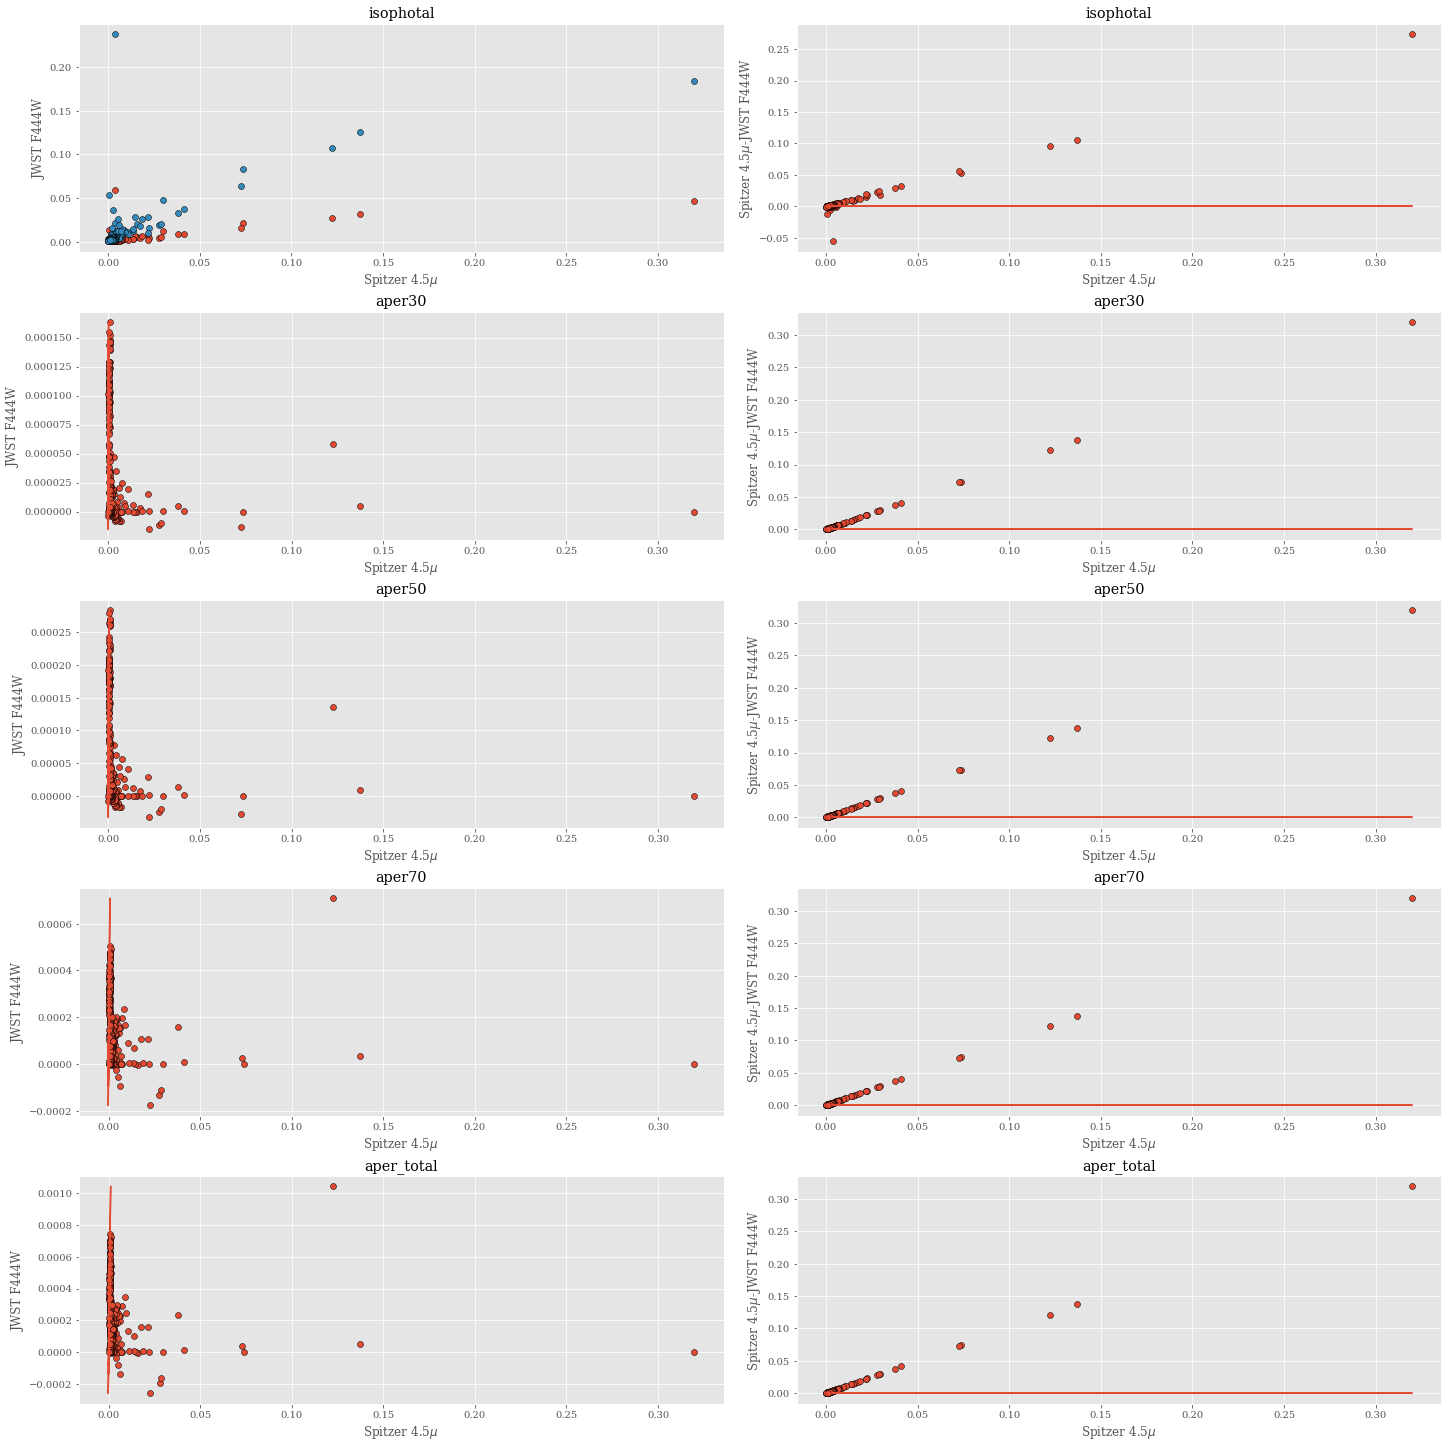

In [ ]:
# plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.color'] = 'brown'
plt.style.use('ggplot')
fig, ax = plt.subplots(5,2,figsize=(20,20),constrained_layout=True)


ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4)
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w']*4)
ax[0][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.f_IR2,0.8*jwst_spitz_cat.f_IR2)
ax[0][1].plot(jwst_spitz_cat.f_IR2,[0]*len(jwst_spitz_cat.f_IR2))
# ax[0][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[0][0].set_ylabel('JWST F444W')
ax[0][0].set_xlabel('Spitzer 4.5$\mu$')

ax[0][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[0][1].set_xlabel('Spitzer 4.5$\mu$')

ax[0][0].set_title(ap_type)
ax[0][1].set_title(ap_type)


ax[1][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
ax[1][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[1][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
# ax[1][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[1][0].set_ylabel('JWST F444W')
ax[1][0].set_xlabel('Spitzer 4.5$\mu$')

ax[1][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[1][1].set_xlabel('Spitzer 4.5$\mu$')

ax[1][0].set_title(ap_type2)
ax[1][1].set_title(ap_type2)


ax[2][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
ax[2][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[2][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
# ax[2][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[2][0].set_ylabel('JWST F444W')
ax[2][0].set_xlabel('Spitzer 4.5$\mu$')

ax[2][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[2][1].set_xlabel('Spitzer 4.5$\mu$')

ax[2][0].set_title(ap_type3)
ax[2][1].set_title(ap_type3)


ax[3][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
ax[3][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[3][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
# ax[3][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[3][0].set_ylabel('JWST F444W')
ax[3][0].set_xlabel('Spitzer 4.5$\mu$')

ax[3][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[3][1].set_xlabel('Spitzer 4.5$\mu$')

ax[3][0].set_title(ap_type4)
ax[3][1].set_title(ap_type4)



ax[4][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
ax[4][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
# ax[4][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
# ax[4][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[4][0].set_ylabel('JWST F444W')
ax[4][0].set_xlabel('Spitzer 4.5$\mu$')

ax[4][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[4][1].set_xlabel('Spitzer 4.5$\mu$')

ax[4][0].set_title(ap_type5)
ax[4][1].set_title(ap_type5)


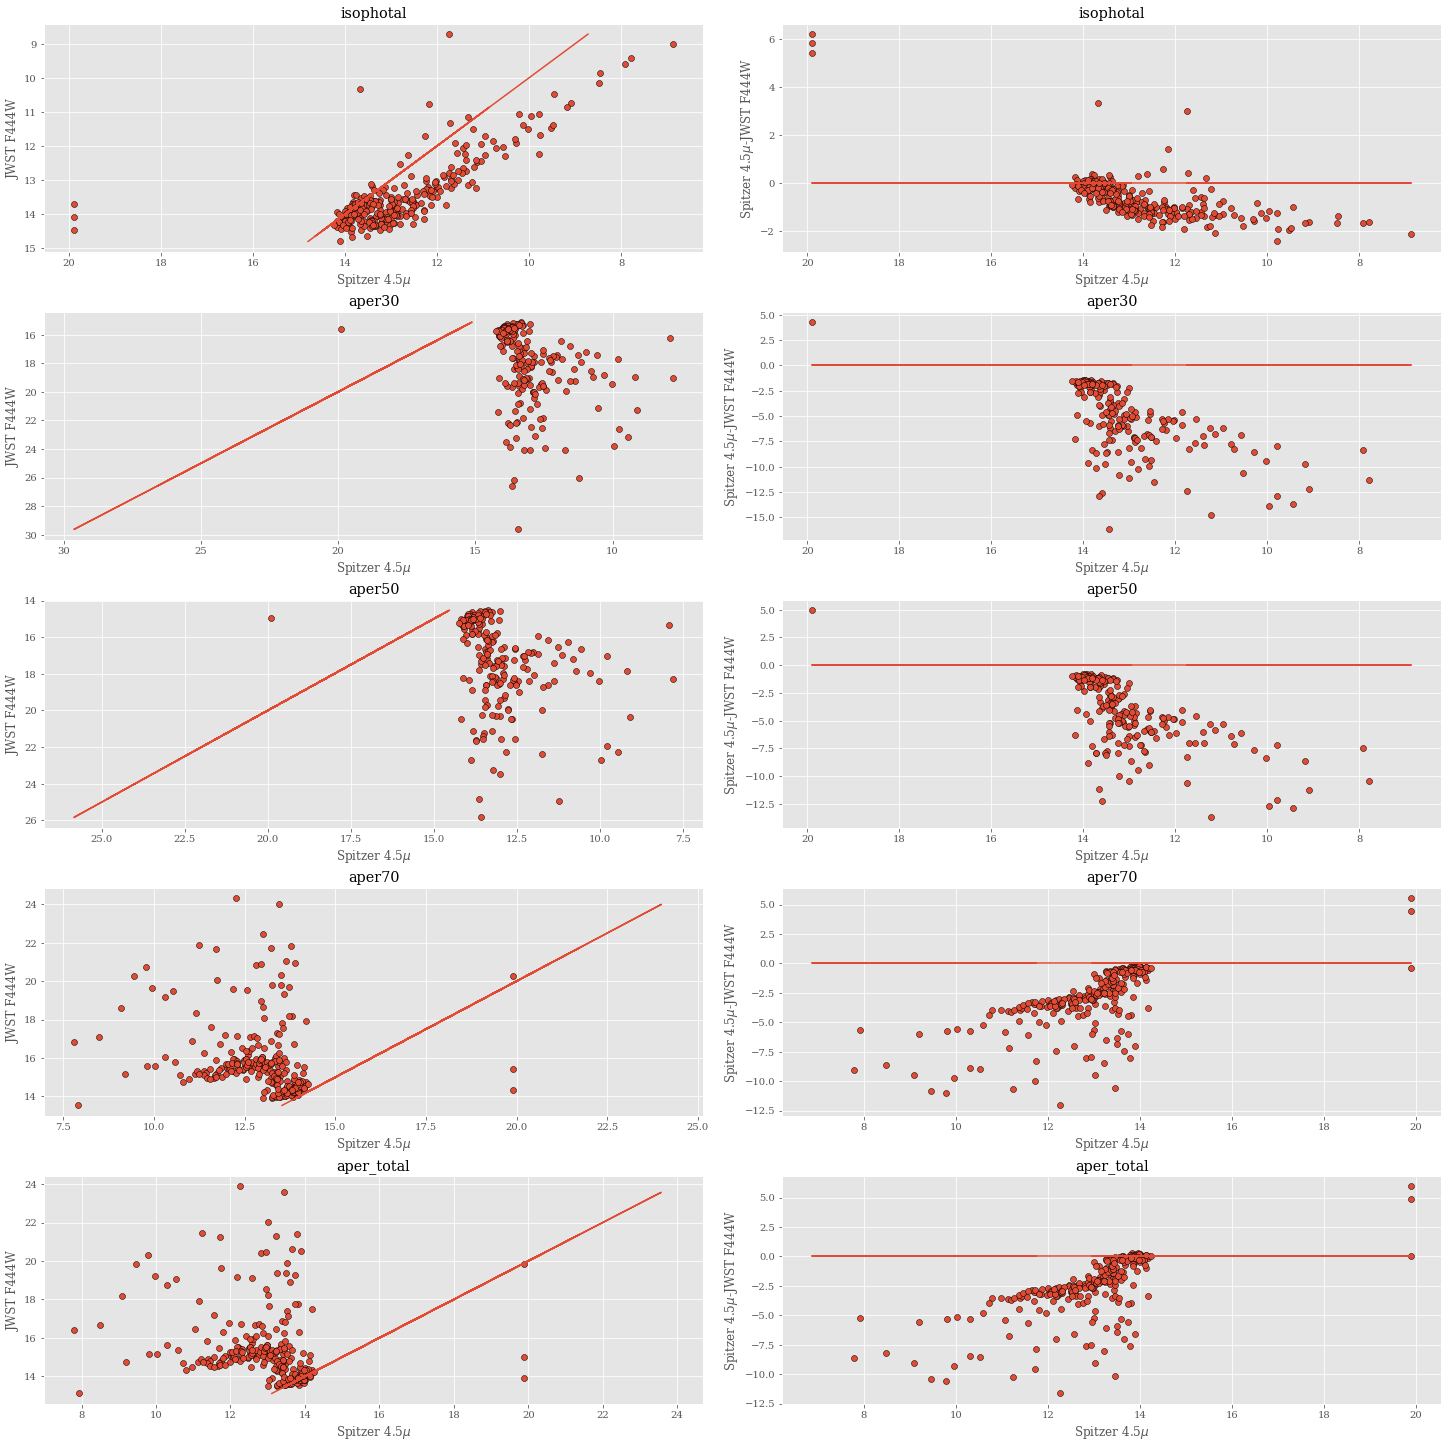

In [ ]:
# plt.hist(jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],bins=np.linspace(-20,10,15))
# idx_1, sep2d_1, _ = match_coordinates_sky(SkyCoord(["10:36:47.3 -58:38:10","10:36:52.3 -58:38:09"],unit=(u.hourangle, u.deg)), s2_sky, nthneighbor=1, storekdtree='kdtree_sky')
# print(sep2d_1)
# spit2m_cat.iloc[idx_1]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['lines.color'] = 'brown'
plt.style.use('ggplot')
fig, ax = plt.subplots(5,2,figsize=(20,20),constrained_layout=True)

ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[2][0].invert_yaxis()
ax[0][0].invert_xaxis()
ax[1][0].invert_xaxis()
ax[2][0].invert_xaxis()
ax[0][1].invert_xaxis()
ax[1][1].invert_xaxis()
ax[2][1].invert_xaxis()
# ax[0][0].set_yscale('log')
# ax[0][0].set_xscale('log')
# axs[2][1].invert_yaxis()

# ax[0][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type+'_'+meas_type2+'_f444w'])
# ax[0][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[0][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][0].plot(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w'])
ax[0][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[0][0].set_ylabel('JWST F444W')
ax[0][0].set_xlabel('Spitzer 4.5$\mu$')

ax[0][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[0][1].set_xlabel('Spitzer 4.5$\mu$')

ax[0][0].set_title(ap_type)
ax[0][1].set_title(ap_type)


# ax[1][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type2+'_f444w'])
# ax[1][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[1][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][0].plot(jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type2+'_'+meas_type+'_f444w'])
ax[1][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[1][0].set_ylabel('JWST F444W')
ax[1][0].set_xlabel('Spitzer 4.5$\mu$')

ax[1][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[1][1].set_xlabel('Spitzer 4.5$\mu$')

ax[1][0].set_title(ap_type2)
ax[1][1].set_title(ap_type2)


# ax[2][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type2+'_f444w'])
# ax[2][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[2][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][0].plot(jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type3+'_'+meas_type+'_f444w'])
ax[2][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[2][0].set_ylabel('JWST F444W')
ax[2][0].set_xlabel('Spitzer 4.5$\mu$')

ax[2][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[2][1].set_xlabel('Spitzer 4.5$\mu$')

ax[2][0].set_title(ap_type3)
ax[2][1].set_title(ap_type3)


# ax[3][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type2+'_f444w'])
# ax[3][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[3][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][0].plot(jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type4+'_'+meas_type+'_f444w'])
ax[3][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[3][0].set_ylabel('JWST F444W')
ax[3][0].set_xlabel('Spitzer 4.5$\mu$')

ax[3][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[3][1].set_xlabel('Spitzer 4.5$\mu$')

ax[3][0].set_title(ap_type4)
ax[3][1].set_title(ap_type4)



# ax[4][0].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][1].scatter(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type2+'_f444w'])
# ax[4][1].plot(jwst_spitz_cat.f_IR2,jwst_spitz_cat.f_IR2-jwst_spitz_cat.f_IR2)
ax[4][0].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][0].plot(jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'],jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][1].scatter(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat[ap_type5+'_'+meas_type+'_f444w'])
ax[4][1].plot(jwst_spitz_cat.mag_IR2,jwst_spitz_cat.mag_IR2-jwst_spitz_cat.mag_IR2)

ax[4][0].set_ylabel('JWST F444W')
ax[4][0].set_xlabel('Spitzer 4.5$\mu$')

ax[4][1].set_ylabel('Spitzer 4.5$\mu$-JWST F444W')
ax[4][1].set_xlabel('Spitzer 4.5$\mu$')

ax[4][0].set_title(ap_type5)
ax[4][1].set_title(ap_type5)


plt.savefig('mag comparison.png',dpi=300)

In [ ]:
m0 = jwst_spitz_cat.isophotal_vegamag_f444w+2.5*np.log10(jwst_spitz_cat.isophotal_flux_f444w)
print(np.mean(m0))
# plt.hist(m0)
# plt.xlim(5.65818991661,5.658189916611)
# print(plt.xlim())

mc = m0-jwst_spitz_cat.isophotal_vegamag_f444w - 2.5*np.log10(jwst_spitz_cat.isophotal_flux_f444w*4)
print(np.mean(mc))

# plt.hist(mc)

5.658189916610624
-1.5051499783198998


[0. 1. 2.]


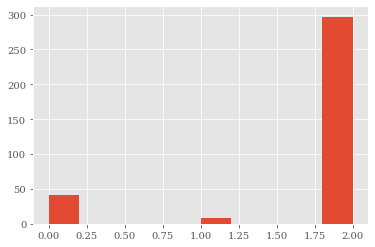

In [ ]:
plt.hist(jwst_spitz_cat.Preds)

print(np.unique(jwst_spitz_cat.Preds))

# Locate all IR-Excess sources from Reiter 2022:


In [ ]:
# IR-Excess sources found in Reiter 2022 (Diving off the Cosmic Cliffs)
reit = ["10:36:42.3 -58:38:04", "10:36:48.0 -58:38:19", "10:36:47.3 -58:38:10", "10:36:46.7 -58:38:05", "10:36:51.5 -58:37:54", "10:36:50.5 -58:37:52",\
    "10:36:51.4 -58:37:48", "10:36:53.8 -58:37:48", "10:36:51.5 -58:37:10", "10:36:54.2 -58:36:26", "10:36:54.4 -58:36:18", "10:36:54.0 -58:37:20",\
        "10:36:53.6 -58:35:20", "10:36:53.1 -58:37:37", "10:36:53.3 -58:37:54", "10:36:52.7 -58:38:05", "10:36:53.1 -58:37:08", "10:36:51.6 -58:36:58",\
        "10:36:52.3 -58:38:09", "10:36:53.9 -58:36:29", "10:37:01.5 -58:37:51", "10:37:02.1 -58:36:58", "10:36:53.9 -58:36:32"]# End of third row is the end of MHO-only sources
sky_1 = SkyCoord(reit,unit=(u.hourangle, u.deg))
ra_1 = sky_1.ra
dec_1 = sky_1.dec

reit_eg = ["10:36:53.7 -58:35:47", "10:36:59.5 -58:39:01", "10:37:07.2 -58:35:36", "10:36:55.2 -58:38:09"]
sky_1 = SkyCoord(reit_eg,unit=(u.hourangle, u.deg))
ra_eg = sky_1.ra
dec_eg = sky_1.dec


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


0.6538133891945108
[0.00159157 0.00090294 0.0004298  0.00133867 0.00079887 0.00024335
 0.00052964 0.00012666]
[159.22573978 159.26708338 159.25002963 159.17813435 159.25097467
 159.19264927 159.2172839  159.19151335]


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_27982/3673498757.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

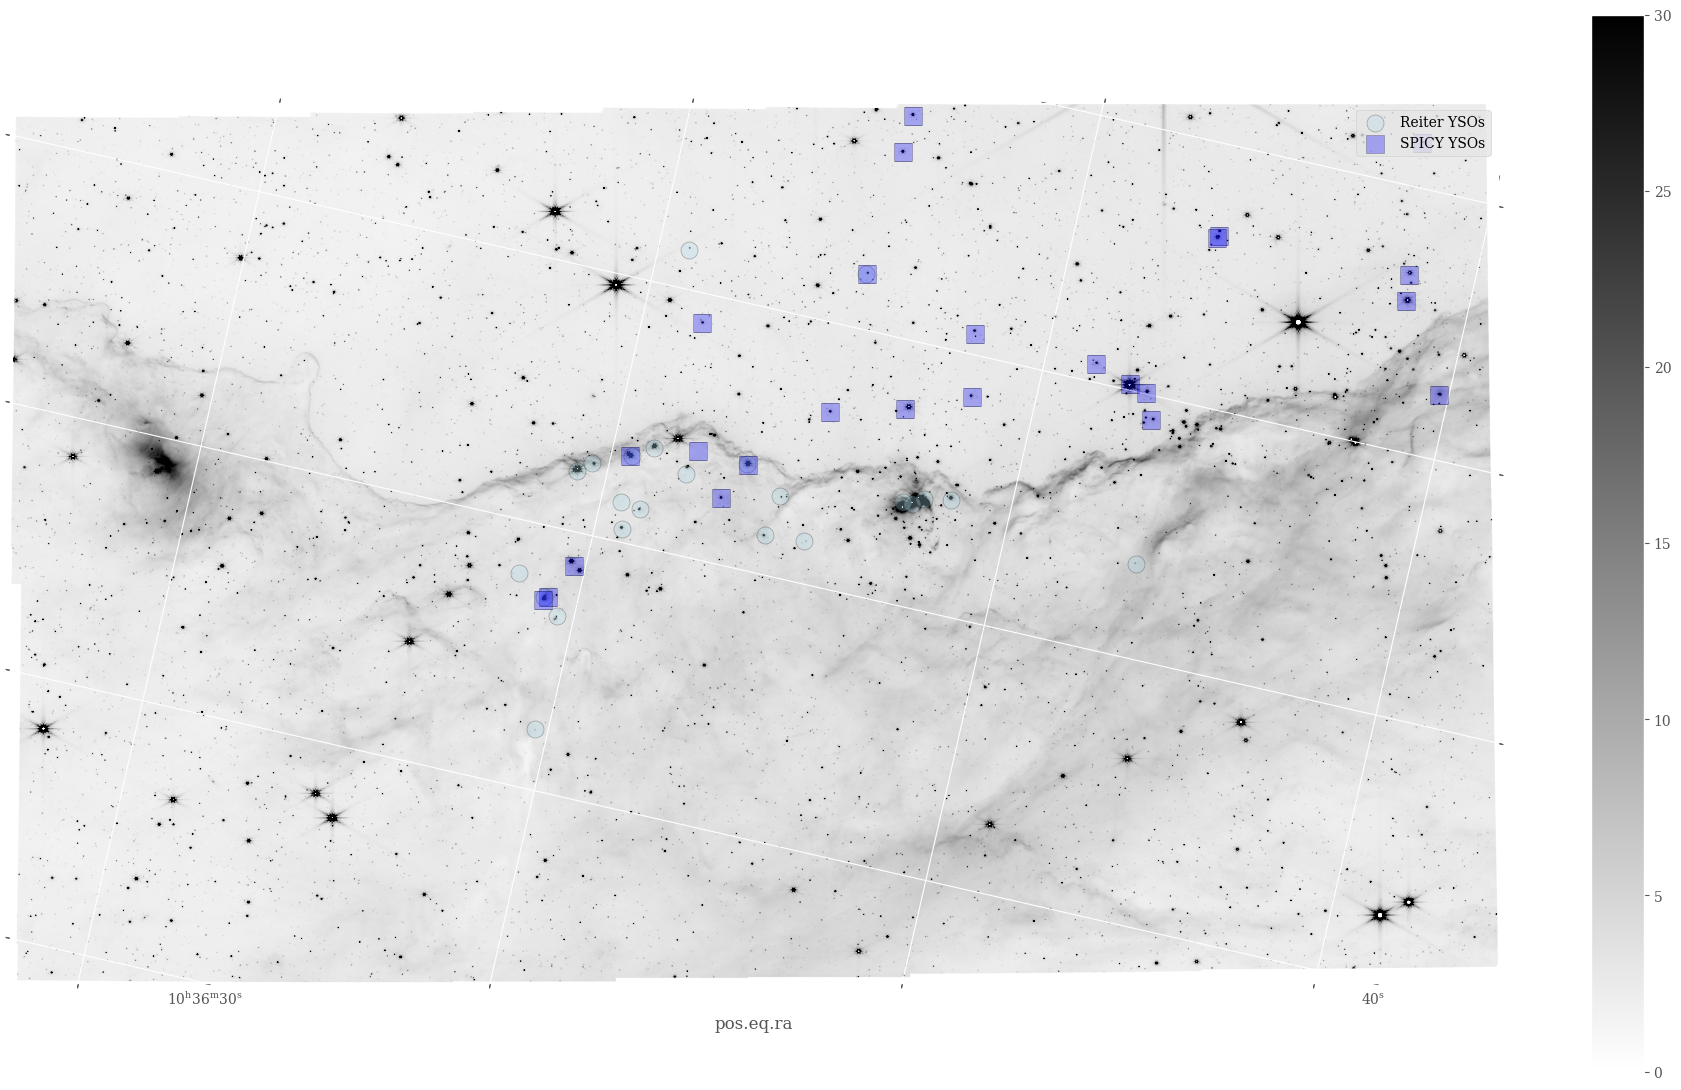

In [ ]:
# Plot image
filter = "clear-f444w"
image_file = path+filter+'/jw02731-o001_t017_nircam_'+filter+'_i2d.fits'


h = fits.getheader(image_file)

f = fits.open(image_file)

wcs = WCS(f[1].header)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(24,14),dpi=100)
ax = plt.subplot(projection=wcs)

plt.grid(color='white', ls='solid')
plt.imshow(f[1].data,cmap='gray_r',vmin=0,vmax=30,origin='lower') #vmax =1500 for f1800w
ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()
plt.colorbar()

ras, decs = wcs.wcs_pix2world(np.linspace(-500,15000,100), np.linspace(-500,16000,100), 1)
print(max(ras)-min(ras))

np8 = np.c_[np.array(jwst_spitz_cat.RA),np.array(jwst_spitz_cat.DEC),np.array(jwst_spitz_cat.mag_IR2),np.array(jwst_spitz_cat.Preds)]

yso = np.where(np8[:,-1]==0)[0]
egs = np.where(np8[:,-1]==1)[0]
sta = np.where(np8[:,-1]==2)[0]
n = np.array([0,1,2,3,4,30,50, 300])
print(np.array(jwst_cat['size'])[n])
print(np.array(jwst_cat['RA'])[n])
plt.scatter(ra_1,dec_1, marker='o', c='lightblue',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter YSOs')
# plt.scatter(ra_eg,dec_eg, marker='o', c='gold',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='Reiter EGs')
# plt.plot([np.array(jwst_spitz_cat.RA)[n],np.array(jwst_spitz_cat.RA)[n]+np.array(jwst_spitz_cat['size'])[n]],[np.array(jwst_spitz_cat.DEC)[n],np.array(jwst_spitz_cat.DEC)[n]], c='r',transform=ax.get_transform('fk5'),label='Size')
plt.scatter(jwst_spitz_spicy_cat.dropna(subset='SPICY').RA.values,jwst_spitz_spicy_cat.dropna(subset='SPICY').DEC.values, marker='s', c='b',s=150, alpha=0.3,transform=ax.get_transform('fk5'),label='SPICY YSOs')
# ax.scatter(np8[yso,0],np8[yso,1], marker='*', c='b',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder YSOs")
# ax.scatter(np8[egs,0],np8[egs,1], marker='*', c='y',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder EGs")
# ax.scatter(np8[sta,0],np8[sta,1], marker='*', c='g',s=60, alpha=0.8, transform=ax.get_transform('fk5'), label = "SPY-finder Stars")
ax.set_ylim(ymax, ymin)
ax.set_xlim(xmax, xmin)
plt.legend(loc=1)
plt.xticks()

# plt.savefig(f"../../ngc3324/CC_w_Reiter_RF_Label_{filter}.png",dpi=100)


In [ ]:
jwst_spitz_spicy_cat

,RA,DEC,size,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,aper30_vegamag_f090w,aper30_vegamag_err_f090w,aper50_vegamag_f090w,aper50_vegamag_err_f090w,aper70_vegamag_f090w,...,e_mag_IR2,mag_IR3,e_mag_IR3,mag_IR4,e_mag_IR4,alpha,Preds,SPICY,SPICY_Class,SPICY_Class_0/1
0,159.225740,-58.614791,0.001592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155,10.058,0.199000,18.350,0.119339,-13.66696,2.0,NaN,NaN,1
1,159.267083,-58.580510,0.000903,13.018948,9.499820,26.101178,16.808694,25.728937,17.127796,22.463460,...,0.049,6.399,0.033000,5.622,0.024000,-0.76836,0.0,NaN,NaN,1
2,159.178134,-58.562264,0.001339,10.788224,8.623969,18.994490,13.663846,17.438456,12.872796,15.503222,...,0.054,7.715,0.037000,7.602,0.030000,-2.50840,0.0,NaN,NaN,1
3,159.250975,-58.592640,0.000799,12.768613,8.807995,26.707967,16.277158,25.058784,15.366050,23.081568,...,0.042,7.082,0.033000,5.858,0.025000,0.55512,0.0,7461.0,FS,0
4,159.225224,-58.626385,0.002905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.107,11.619,0.182000,18.350,0.119339,-12.95520,2.0,7441.0,ClassI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,159.250262,-58.591194,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.075,11.087,0.080000,9.977,0.075000,-0.17304,0.0,7461.0,FS,0
342,159.276678,-58.588333,0.000087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.096,10.969,0.095000,10.266,0.056000,-1.23412,0.0,7475.0,ClassII,0
343,159.194087,-58.634834,0.000113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.150,18.524,0.144951,18.350,0.119339,-11.20696,2.0,NaN,NaN,1
344,159.196622,-58.636152,0.000089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.086,9.799,0.064000,8.857,0.066000,0.62892,0.0,7423.0,ClassI,0


In [ ]:
jwst_spitz_spicy_cat.to_csv('../Phase_4__2MASS_UpperLim_Classification/Scripts/CC_Webb_NIRCam_MIRI_Spitz_2m_w_SPICY_Preds_Dec142022.csv')

In [ ]:
jwst_spitz_spicy_cat[bands].head(-1)

,isophotal_vegamag_f090w,isophotal_vegamag_err_f090w,isophotal_vegamag_f187n,isophotal_vegamag_err_f187n,isophotal_vegamag_f200w,isophotal_vegamag_err_f200w,isophotal_vegamag_f335m,isophotal_vegamag_err_f335m,isophotal_vegamag_f444w,isophotal_vegamag_err_f444w,isophotal_vegamag_f444w-f470n,isophotal_vegamag_err_f444w-f470n,isophotal_vegamag_f770w,isophotal_vegamag_err_f770w,isophotal_vegamag_f1130w,isophotal_vegamag_err_f1130w,isophotal_vegamag_f1280w,isophotal_vegamag_err_f1280w,isophotal_vegamag_f1800w,isophotal_vegamag_err_f1800w
0,NaN,NaN,NaN,NaN,11.416486,8.303678,9.571966,6.622966,8.722870,6.138027,7.618336,6.927048,NaN,NaN,2.490942,3.291690,3.198588,3.295285,2.127154,3.646676
1,13.018948,9.499820,10.458064,9.620335,10.271229,8.407819,9.307425,7.052663,8.999677,6.774787,8.372790,7.865050,6.365633,8.991813,5.128203,10.207795,5.768326,9.647292,5.130328,10.367700
2,10.788224,8.623969,8.925118,8.931601,9.253842,8.113905,9.154792,7.299540,9.411055,7.225036,8.735966,8.203675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12.768613,8.807995,11.076486,9.084266,10.835843,8.253004,9.847233,6.875179,9.588167,6.607979,8.755222,7.645574,6.812131,9.162366,5.519887,10.350086,6.119365,9.701253,4.877629,9.874045
4,NaN,NaN,NaN,NaN,10.431058,8.211114,10.121664,7.122750,10.765682,7.134154,8.819429,7.953166,3.982669,6.105566,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,NaN,NaN,13.627945,10.956236,NaN,NaN,14.141653,9.312871,14.151035,9.118317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341,NaN,NaN,14.093314,11.073706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.809189,7.862048,9.391851,6.829266,9.882655,6.613156,8.542321,6.813381
342,NaN,NaN,13.076457,11.300047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.650013,7.253322
343,NaN,NaN,NaN,NaN,18.138087,11.816275,16.561453,10.235612,14.007175,8.742403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
jwst_spitz_spicy_cat.iloc[31]

RA                             159.197247
DEC                            -58.635838
size                             0.000431
isophotal_vegamag_f090w         20.341049
isophotal_vegamag_err_f090w     13.092627
                                  ...    
alpha                             0.62892
Preds                                 0.0
SPICY                              7423.0
SPICY_Class                     ClassI   
SPICY_Class_0/1                         0
Name: 31, Length: 224, dtype: object

# SPICY

In [40]:
# print('J'+np.array(jwst_spitz_cat.RA)+np.array(jwst_spitz_cat.DEC))
def deg_to_hrminsec(deg):
    deg = deg*u.deg
    h = deg.to(u.hourangle)/u.hourangle
    m = (h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:04.1f}".format(s)
def deghr_to_hrminsec(deg):
    h = deg
    # print(Angle(deg,u.hourangle).hms)
    m = 60-(h%1)*60
    s = (m%1)*60
    return str(int(h))+"{:02d}".format(int(m))+"{:02d}".format(int(s))

jwst_num = []


for i, r in enumerate(np.array(jwst_spitz_cat.RA)):
    jwst_num.append('J'+deg_to_hrminsec(r)+deghr_to_hrminsec(np.array(jwst_spitz_cat.DEC)[i]))

# Distribution of nan values and objects classified as YSOs/Stars

array([[<AxesSubplot:title={'center':'Preds'}>]], dtype=object)

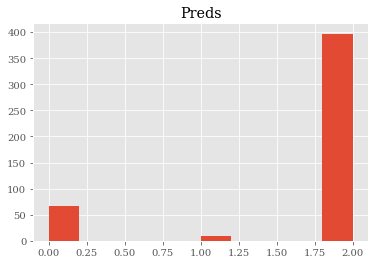

In [31]:
jwst_spitz_cat.hist('Preds')

In [32]:
np.count_nonzero(~np.isnan(jwst_spitz_cat[ap_type+'_'+meas_type+'_f444w']))

339

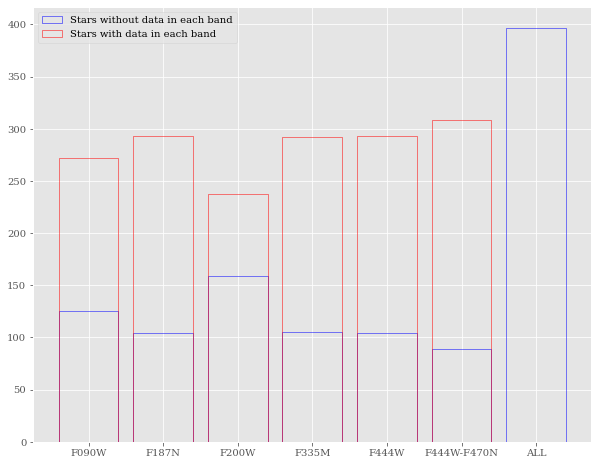

In [33]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].shape[0] - jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='b',label='Stars without data in each band')

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],fill=False,edgecolor='r',label='Stars with data in each band')

# plt.plot(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f090w'])),\
#     np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f200w'])),\
#         np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w'])),\
#             np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[sta].dropna().shape[0]],color='r')
plt.legend()

67


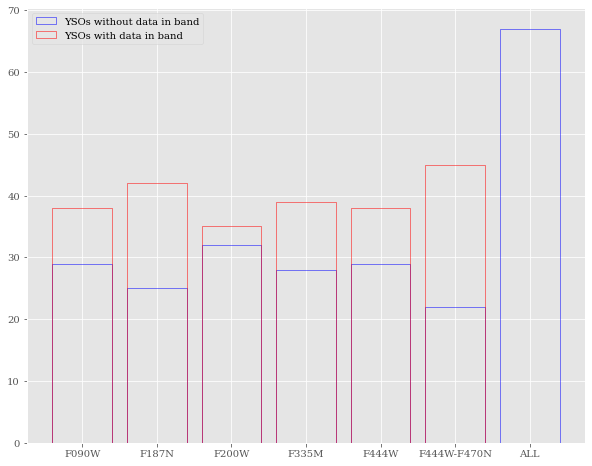

In [34]:
plt.subplots(figsize=(10,8))

plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', 'ALL'],[np.count_nonzero(np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].shape[0] - jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='b',label='YSOs without data in band')


plt.bar(['F090W','F187N','F200W','F335M','F444W','F444W-F470N', "ALL"],[np.count_nonzero(~np.isnan(jwst_spitz_cat.loc[yso][ap_type+'_'+meas_type+'_f090w'])),\
    np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f187n'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f200w'])),\
        np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f335m'])),np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w'])),\
            np.count_nonzero(~np.isnan(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_f444w-f470n'])),jwst_spitz_cat.iloc[yso].dropna().shape[0]],fill=False,edgecolor='r',label='YSOs with data in band')

print(jwst_spitz_cat.iloc[yso].shape[0])

plt.legend()

In [40]:
# # plt.subplots(figsize=(12,12))

# bands = [idx for idx in jwst_spitz_cat.columns if (idx[:3] == 'iso' and idx[-9:-6] != 'err')] 
# print(bands)
# pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[yso][bands],figsize=(12,12),color='turquoise')
# pd.plotting.scatter_matrix(jwst_spitz_cat.iloc[sta][bands],figsize=(12,12),color='r')

In [41]:
bands

['isophotal_vegamag_f090w',
 'isophotal_flux_f090w',
 'isophotal_vegamag_f187n',
 'isophotal_flux_f187n',
 'isophotal_vegamag_f200w',
 'isophotal_flux_f200w',
 'isophotal_vegamag_f335m',
 'isophotal_flux_f335m',
 'isophotal_vegamag_f444w',
 'isophotal_flux_f444w',
 'isophotal_vegamag_f444w-f470n',
 'isophotal_vegamag_err_f444w-f470n',
 'isophotal_flux_f444w-f470n',
 'isophotal_flux_err_f444w-f470n',
 'isophotal_vegamag_f770w',
 'isophotal_flux_f770w',
 'isophotal_vegamag_f1130w',
 'isophotal_vegamag_err_f1130w',
 'isophotal_flux_f1130w',
 'isophotal_flux_err_f1130w',
 'isophotal_vegamag_f1280w',
 'isophotal_vegamag_err_f1280w',
 'isophotal_flux_f1280w',
 'isophotal_flux_err_f1280w',
 'isophotal_vegamag_f1800w',
 'isophotal_vegamag_err_f1800w',
 'isophotal_flux_f1800w',
 'isophotal_flux_err_f1800w']

(array([0.14141414, 0.36767677, 0.08484848, 0.31111111, 0.02828283,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([10.        , 11.07142857, 12.14285714, 13.21428571, 14.28571429,
        15.35714286, 16.42857143, 17.5       , 18.57142857, 19.64285714,
        20.71428571, 21.78571429, 22.85714286, 23.92857143, 25.        ]),
 [<matplotlib.patches.Polygon at 0x16b41f040>])

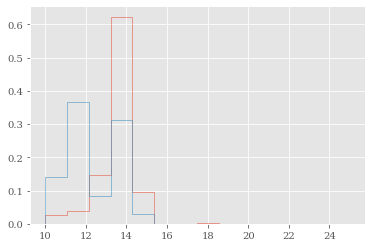

In [42]:
band = 'f444w'
plt.hist(jwst_spitz_cat.iloc[sta][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='stars',density=True,histtype='step')
plt.hist(jwst_spitz_cat.iloc[yso][ap_type+'_'+meas_type+'_'+band],bins=np.linspace(10,25,15),label='ysos',density=True,histtype='step')

In [47]:
from sklearn.manifold import TSNE
# print(bands)

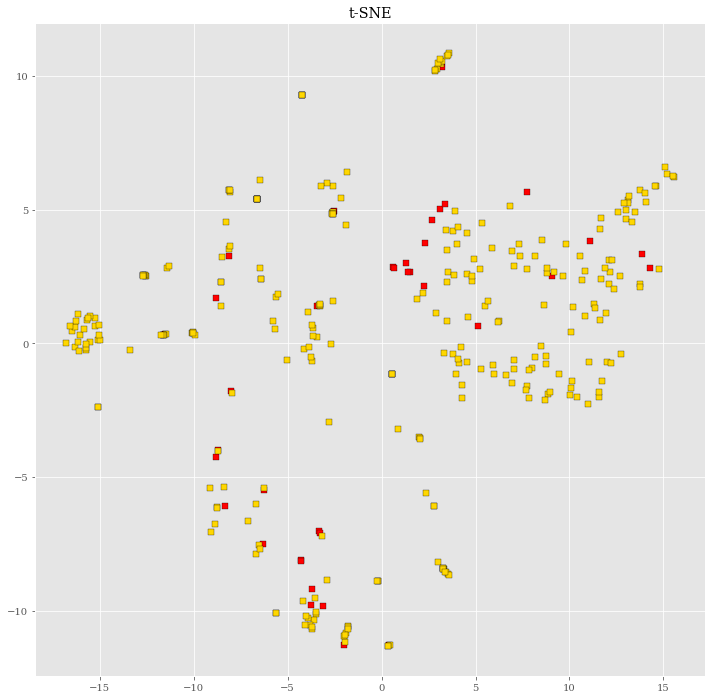

In [48]:
tsne = TSNE(
        n_components=2,
        init="random",
        random_state=11,
        perplexity=30,
        learning_rate="auto",
        n_iter=300)

droppna = jwst_spitz_spicy_cat.fillna(0)
Y = tsne.fit_transform(droppna[bands])

lw = 0.3

plt.subplots(figsize=(12,12))

plt.rcParams["scatter.edgecolors"]  = 'k'
plt.rcParams["font.family"] = "times"
plt.title("t-SNE")

plt.scatter(Y[np.where(droppna.Preds==0)[0], 0], Y[np.where(droppna.Preds==0)[0], 1], c="red",marker='s',linewidths=lw,label='Stars')
plt.scatter(Y[np.where(droppna.Preds==2)[0], 0], Y[np.where(droppna.Preds==2)[0], 1], c="gold",marker='s',linewidths=lw,label='EG')
    

In [ ]:
cols = np.r_[bands, ['Preds']]
fillna = jwst_spitz_cat[cols]
for band in bands[:6]:
    print(band)
    min = np.nanmax(jwst_spitz_cat[[band]])
    print(min+5)
    fillna[band].fillna(min+5,inplace=True)


fillna.head()

isophotal_vegamag_f090w
30.56144249722696
isophotal_vegamag_f187n
26.240837226461764
isophotal_vegamag_f200w
23.13808652440421
isophotal_vegamag_f335m
22.173117395850717
isophotal_vegamag_f444w
22.672818919714175
isophotal_vegamag_f444w-f470n
22.842365482839682


/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fillna[band].fillna(min+5,inplace=True)
/var/folders/qy/7yz8bmv96hx8rndql_rfdz_80000gn/T/ipykernel_24154/601905150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,isophotal_vegamag_f090w,isophotal_vegamag_f187n,isophotal_vegamag_f200w,isophotal_vegamag_f335m,isophotal_vegamag_f444w,isophotal_vegamag_f444w-f470n,mag_J,mag_H,mag_Ks,mag_IR1,mag_IR2,mag_IR3,mag_IR4,Preds
0,30.561442,26.240837,11.416486,10.133513,8.722870,7.618336,12.242,10.990,10.103,9.117,8.505,8.040,6.691,0.0
1,10.044549,8.912283,9.042986,8.882913,8.725649,22.842365,11.740,11.466,11.413,11.400,11.430,11.342,11.373,2.0
2,30.561442,26.240837,10.271229,9.307425,8.999677,22.842365,10.772,9.712,8.685,7.416,6.873,6.399,5.622,0.0
3,10.788224,8.925118,9.253842,9.154792,9.411055,8.735966,8.283,7.807,7.665,7.651,7.792,7.715,7.602,0.0
4,30.561442,26.240837,10.835843,9.847233,9.588167,8.755222,11.693,10.819,9.871,8.670,7.916,7.082,5.858,0.0
